In [41]:
import pandas as pd

# Load the saved CSV file
fdv_df = pd.read_csv("fdv_and_mc_data_raw.csv")

# Optional: parse timestamps if needed
fdv_df['timestamp'] = pd.to_datetime(fdv_df['timestamp'])


In [42]:
fdv_df['token_name'].nunique()

5729

/var/folders/c0/h2bpt1811s97x40k6_8hx8800000gn/T/ipykernel_16292/327236007.py:55: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/Users/cedriclion/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


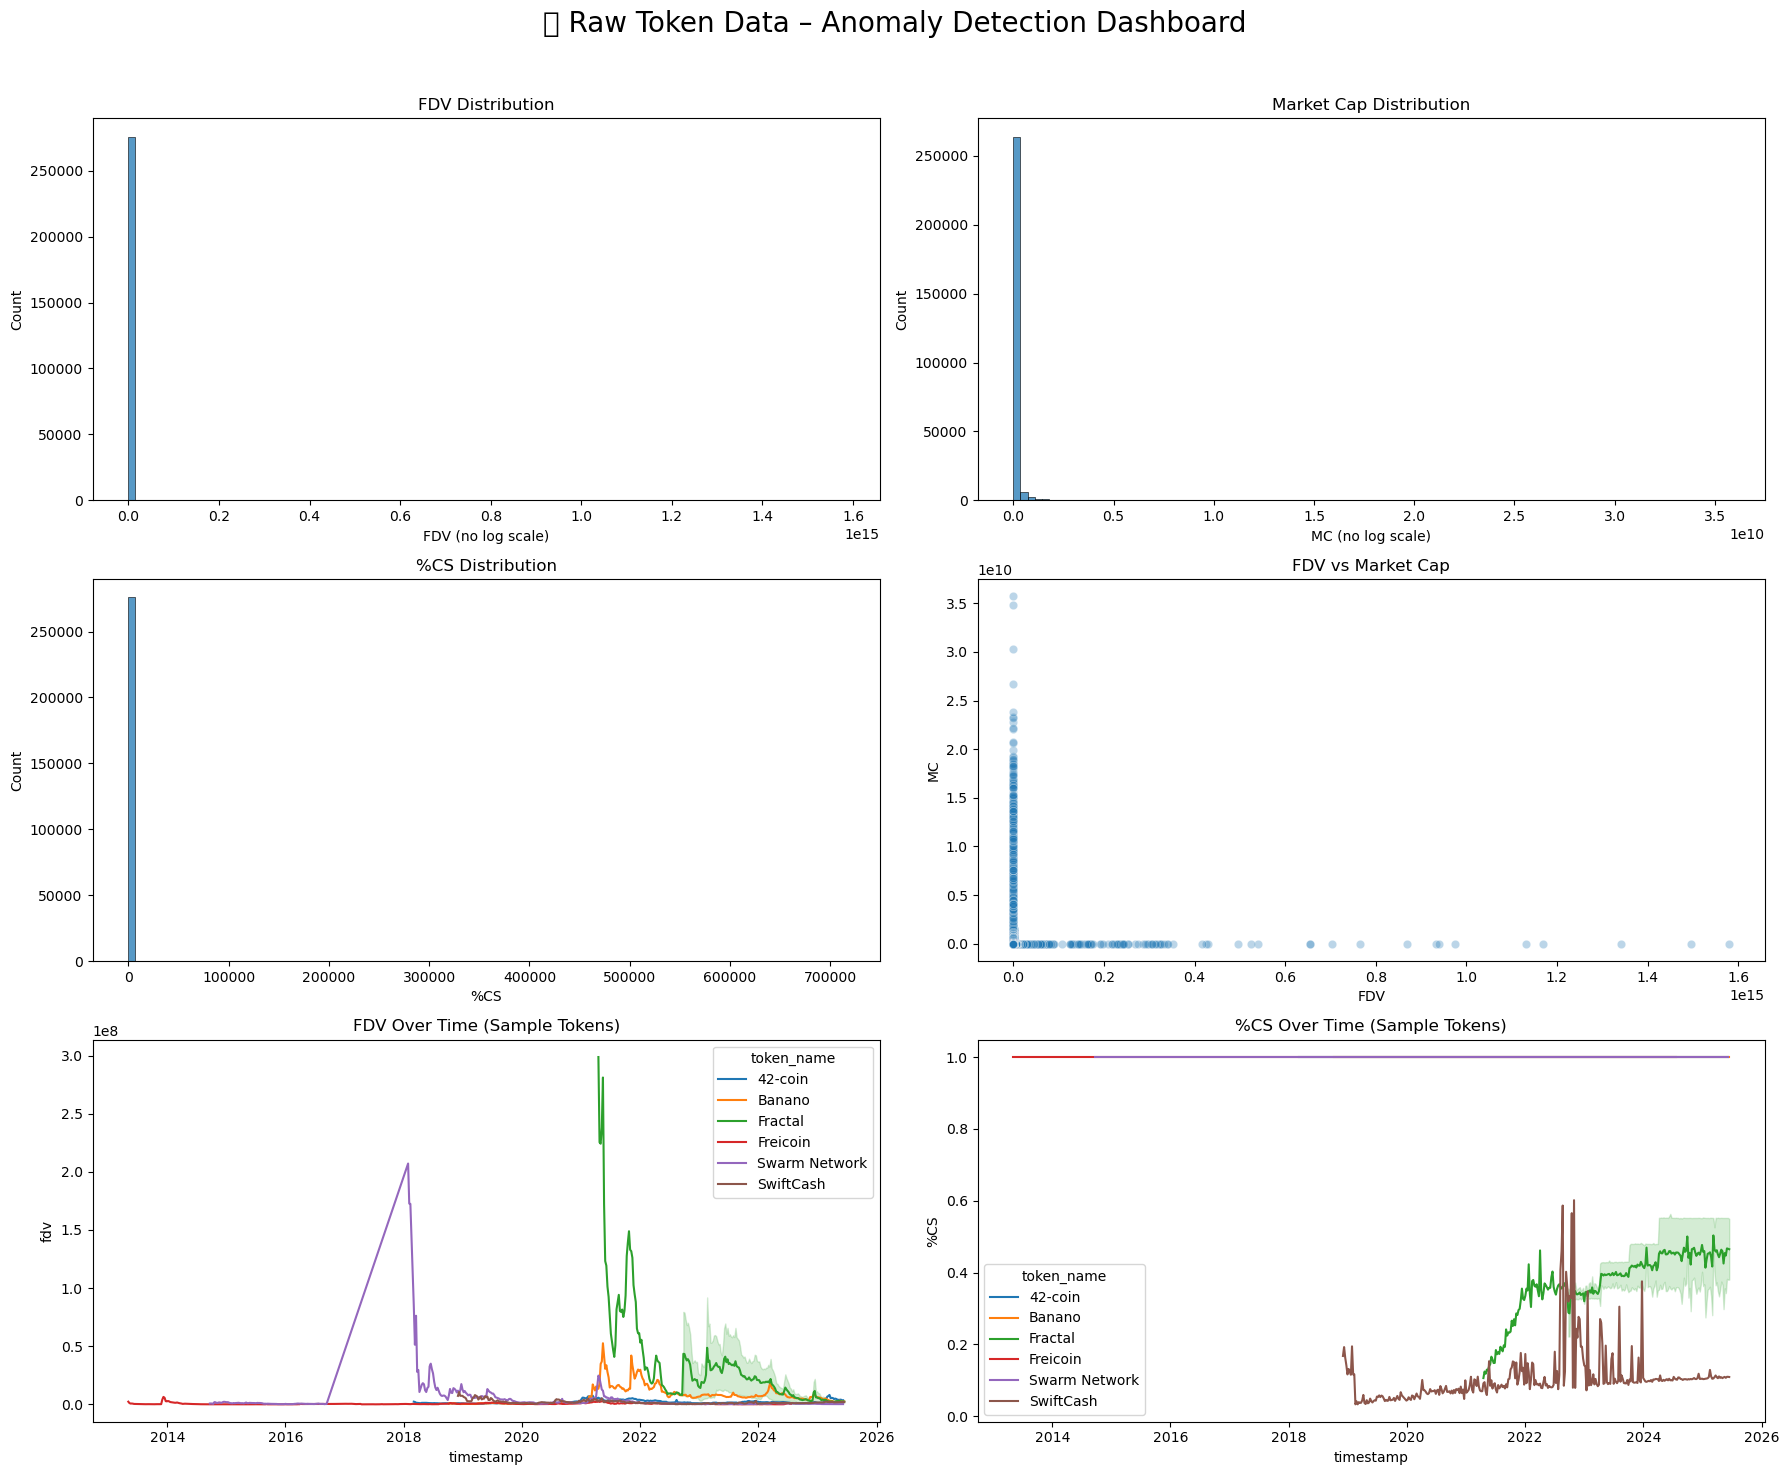

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Copy to avoid modifying raw data
plot_df = fdv_df.copy()

# Ensure datetime
plot_df['timestamp'] = pd.to_datetime(plot_df['timestamp'])

# Compute %CS
plot_df['%CS'] = plot_df['market_cap'] / plot_df['fdv']

# Replace inf and drop bad rows
plot_df.replace([np.inf, -np.inf], np.nan, inplace=True)
plot_df.dropna(subset=['fdv', 'market_cap', '%CS'], inplace=True)
plot_df = plot_df[(plot_df['fdv'] > 0) & (plot_df['market_cap'] > 0)]

# Sample top 6 tokens
top_tokens = plot_df['token_name'].value_counts().head(6).index
sample_df = plot_df[plot_df['token_name'].isin(top_tokens)].copy()

# Create figure
fig, axs = plt.subplots(3, 2, figsize=(18, 15))
fig.suptitle("🔍 Raw Token Data – Anomaly Detection Dashboard", fontsize=20)

# Plot 1: FDV distribution
sns.histplot(plot_df['fdv'], bins=100, ax=axs[0, 0])
axs[0, 0].set_title("FDV Distribution")
axs[0, 0].set_xlabel("FDV (no log scale)")

# Plot 2: Market Cap distribution
sns.histplot(plot_df['market_cap'], bins=100, ax=axs[0, 1])
axs[0, 1].set_title("Market Cap Distribution")
axs[0, 1].set_xlabel("MC (no log scale)")

# Plot 3: %CS distribution
sns.histplot(plot_df['%CS'], bins=100, ax=axs[1, 0])
axs[1, 0].set_title("%CS Distribution")

# Plot 4: FDV vs Market Cap
sns.scatterplot(data=plot_df, x="fdv", y="market_cap", ax=axs[1, 1], alpha=0.3)
axs[1, 1].set_title("FDV vs Market Cap")
axs[1, 1].set_xlabel("FDV")
axs[1, 1].set_ylabel("MC")

# Plot 5: FDV over time for sample tokens
sns.lineplot(data=sample_df, x="timestamp", y="fdv", hue="token_name", ax=axs[2, 0])
axs[2, 0].set_title("FDV Over Time (Sample Tokens)")

# Plot 6: %CS over time for sample tokens
sns.lineplot(data=sample_df, x="timestamp", y="%CS", hue="token_name", ax=axs[2, 1])
axs[2, 1].set_title("%CS Over Time (Sample Tokens)")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [44]:
import pandas as pd
import numpy as np

# ---------- PARAMETERS ----------
start_date = "2022-06-01"
end_date = "2025-06-01"
min_weeks_per_token = 5
min_avg_mc = 5_000_000  # Minimum average market cap per token

# ---------- STEP 1: PREPARE DATA ----------
df = fdv_df.copy()

# Rename columns
df.rename(columns={
    'token_name': 'symbol',
    'fdv': 'FDV',
    'market_cap': 'MC'
}, inplace=True)

# Parse dates
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Compute circulating supply ratio
df['%CS'] = df['MC'] / df['FDV']

# Drop invalid rows (FDV=0, NaNs, inf, etc.)
df = df.replace([np.inf, -np.inf], np.nan)
df = df[df['FDV'] > 0]
df = df[df['MC'] > 0]
df = df[df['%CS'].notna() & (df['%CS'] > 0) & (df['%CS'] <= 1)]

# ---------- STEP 2: FILTER BY DATE RANGE ----------
df = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)].copy()

# ---------- STEP 3: REMOVE EXTREME OUTLIERS ----------
df = df[
    (df['FDV'] < df['FDV'].quantile(0.99)) &
    (df['MC'] < df['MC'].quantile(0.99))
].copy()

# ---------- STEP 3.5: REMOVE OBVIOUSLY BROKEN / UNREALISTIC DATA ----------
df = df[df['FDV'] < 1e12]                              # FDV must be < $1T
df = df[df['FDV'] <= df['MC'] * 100]                   # FDV should not be 100x MC
df = df[~((df['FDV'] > 1e10) & (df['MC'] < 1e6))]       # Drop extreme mismatches

# ---------- STEP 4: FILTER TOKENS WITH ENOUGH DATA ----------
token_counts = df['symbol'].value_counts()
valid_tokens = token_counts[token_counts >= min_weeks_per_token].index
df = df[df['symbol'].isin(valid_tokens)].copy()

# ---------- STEP 5: REMOVE CONSTANT OR BROKEN TOKENS ----------
fdv_std = df.groupby('symbol')['FDV'].std()
cs_std = df.groupby('symbol')['%CS'].std()
valid_tokens = fdv_std[(fdv_std > 0) & (cs_std > 0)].index
df = df[df['symbol'].isin(valid_tokens)].copy()

# ---------- STEP 6: REMOVE TOKENS WITH NO UNLOCKING DYNAMICS ----------
cs_range = df.groupby('symbol')['%CS'].agg(['min', 'max'])
valid_tokens = cs_range[cs_range['max'] > cs_range['min']].index
df = df[df['symbol'].isin(valid_tokens)].copy()

# ---------- STEP 6.5: REMOVE TOKENS WITH >95% CIRCULATING SUPPLY ----------
cs_max = df.groupby('symbol')['%CS'].max()
valid_tokens = cs_max[cs_max < 0.95].index
df = df[df['symbol'].isin(valid_tokens)].copy()

# ---------- STEP 6.6: REMOVE TOKENS WITH NEGATIVE %CS JUMPS (>10%) ----------
df_sorted = df.sort_values(['symbol', 'timestamp']).copy()
df_sorted['cs_diff'] = df_sorted.groupby('symbol')['%CS'].diff()
tokens_with_cs_drops = df_sorted[df_sorted['cs_diff'] < -0.10]['symbol'].unique()

print(f"❌ Removing {len(tokens_with_cs_drops)} tokens with abnormal %CS drops:")

df = df[~df['symbol'].isin(tokens_with_cs_drops)].copy()

# ---------- STEP 7: REMOVE VERY LOW CAP TOKENS ----------
avg_mc = df.groupby('symbol')['MC'].mean()
valid_tokens = avg_mc[avg_mc >= min_avg_mc].index
df = df[df['symbol'].isin(valid_tokens)].copy()

# ---------- STEP 8: KEEP ONLY TOP 500 BY LATEST FDV ----------
latest_date = df['timestamp'].max()
top_500_tokens = (
    df[df['timestamp'] == latest_date]
    .groupby("symbol")["FDV"]
    .mean()
    .sort_values(ascending=False)
    .head(1000)
    .index
)
df = df[df['symbol'].isin(top_500_tokens)].copy()

# ---------- STEP 9: COMPUTE TGE DATE + DAYS FROM TGE ----------
df['TGE_date'] = df.groupby('symbol')['timestamp'].transform('min')
df['day_from_TGE'] = (df['timestamp'] - df['TGE_date']).dt.days
df.drop(columns=['TGE_date'], inplace=True)

# ---------- STEP 10: CLEANUP ----------
df = df.drop_duplicates(subset=['timestamp', 'symbol']).sort_values(['symbol', 'timestamp'])
df = df.reset_index(drop=True)
df = df[['timestamp', 'symbol', 'day_from_TGE', '%CS', 'MC', 'FDV']]

print(f"✅ Final dataset: {df.shape[0]} rows, {df['symbol'].nunique()} unique tokens")


❌ Removing 269 tokens with abnormal %CS drops:
✅ Final dataset: 66253 rows, 826 unique tokens


/var/folders/c0/h2bpt1811s97x40k6_8hx8800000gn/T/ipykernel_16292/3916854889.py:58: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/Users/cedriclion/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


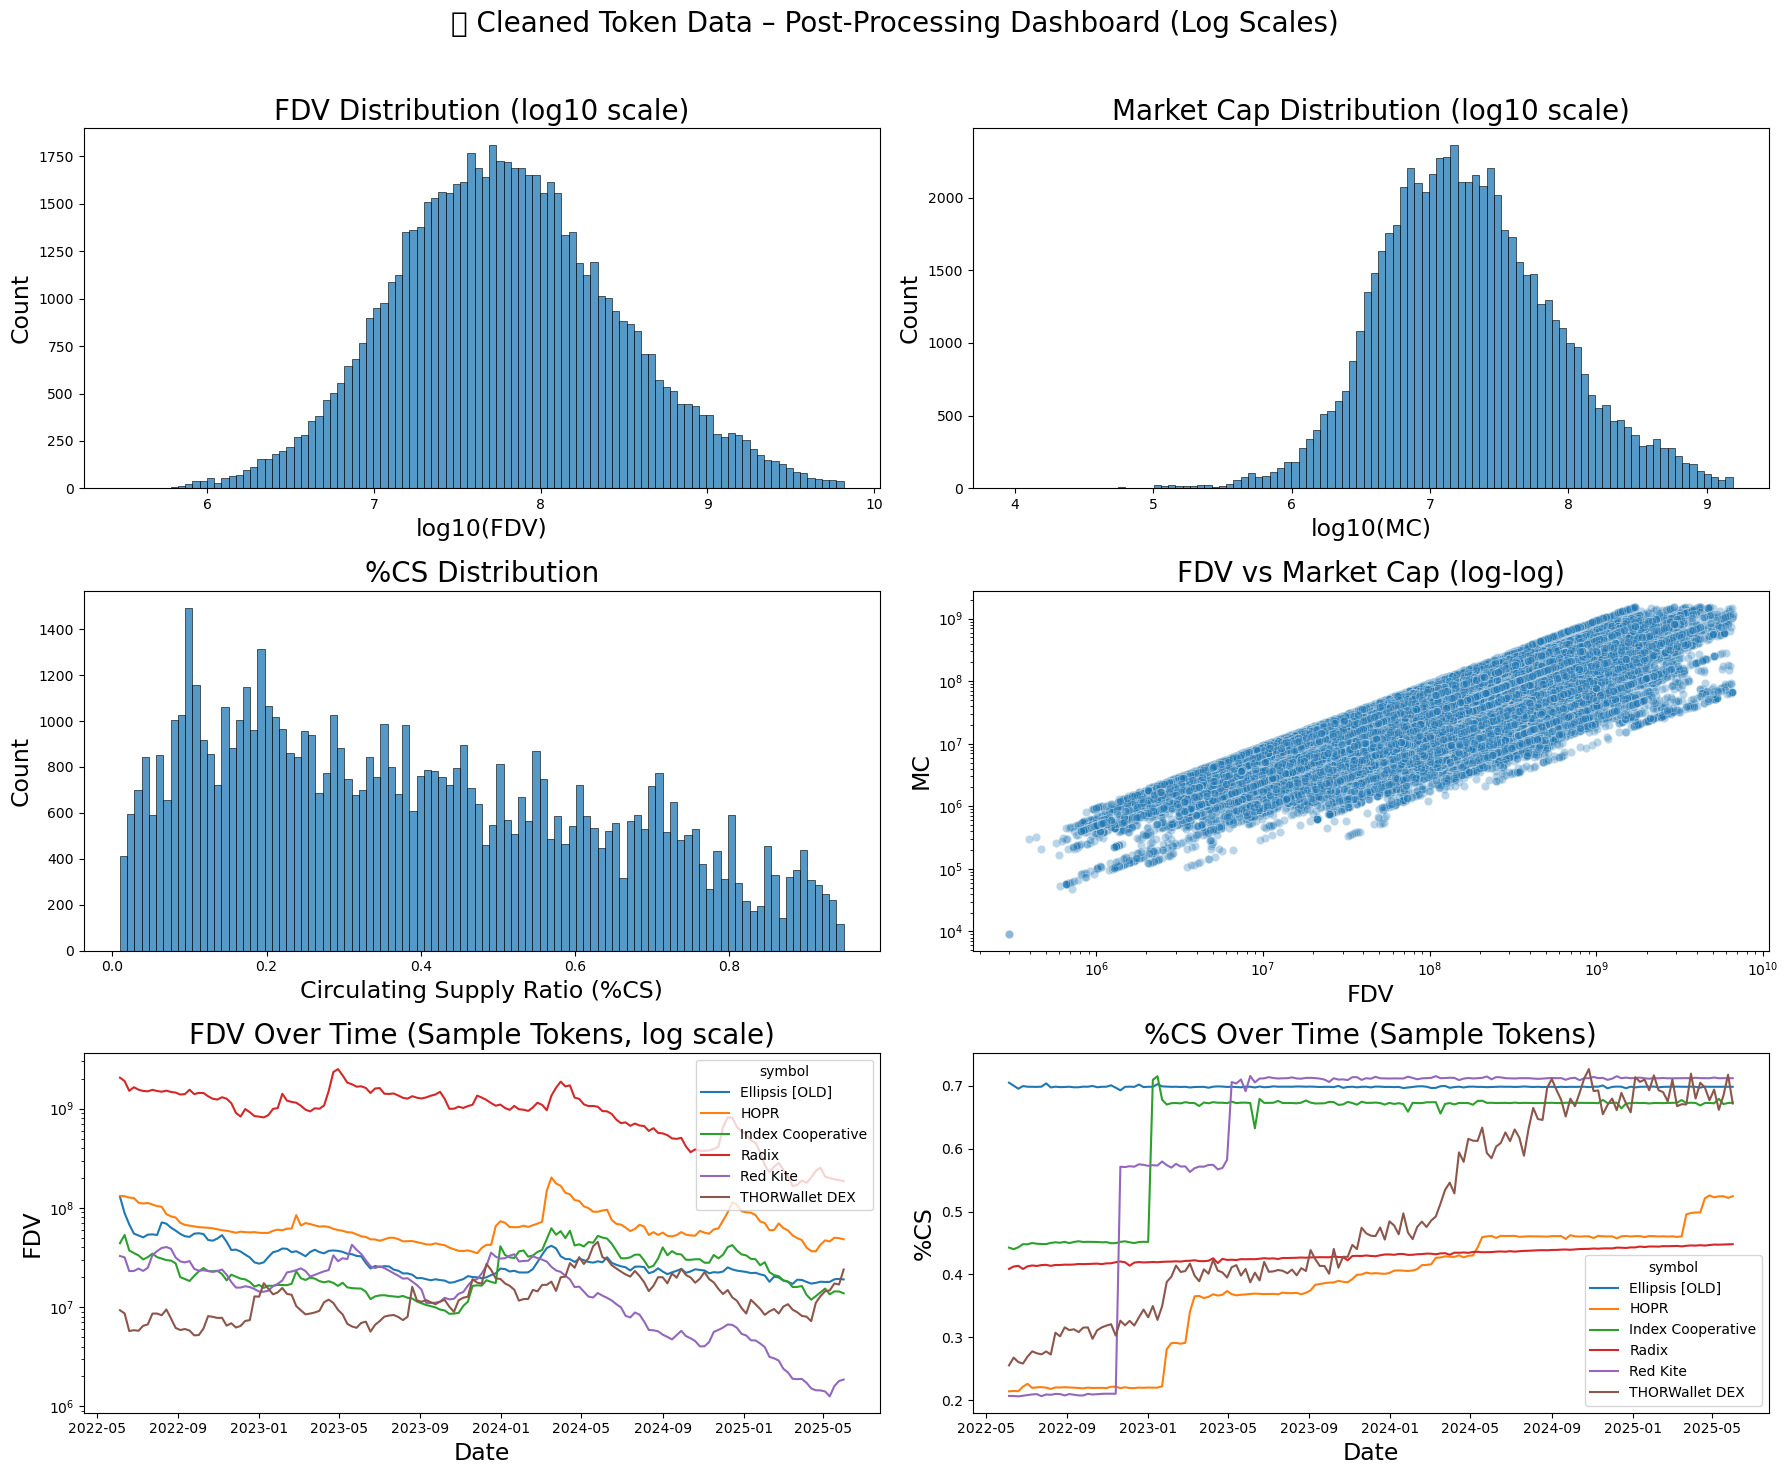

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Copy the cleaned dataset
plot_df = df.copy()

# Replace zeros to avoid issues with log scale
plot_df = plot_df[(plot_df['FDV'] > 0) & (plot_df['MC'] > 0)]

# Sample top 6 tokens with most data points
top_tokens = plot_df['symbol'].value_counts().head(6).index
sample_df = plot_df[plot_df['symbol'].isin(top_tokens)].copy()

# Create figure layout
fig, axs = plt.subplots(3, 2, figsize=(18, 15))
fig.suptitle("📊 Cleaned Token Data – Post-Processing Dashboard (Log Scales)", fontsize=20)

# Plot 1: FDV distribution (log scale)
sns.histplot(np.log10(plot_df['FDV']), bins=100, ax=axs[0, 0])
axs[0, 0].set_title("FDV Distribution (log10 scale)", fontsize=20)
axs[0, 0].set_xlabel("log10(FDV)", fontsize=17)
axs[0, 0].set_ylabel("Count", fontsize=17)

# Plot 2: Market Cap distribution (log scale)
sns.histplot(np.log10(plot_df['MC']), bins=100, ax=axs[0, 1])
axs[0, 1].set_title("Market Cap Distribution (log10 scale)", fontsize=20)
axs[0, 1].set_xlabel("log10(MC)", fontsize=17)
axs[0, 1].set_ylabel("Count", fontsize=17)

# Plot 3: %CS distribution (linear)
sns.histplot(plot_df['%CS'], bins=100, ax=axs[1, 0])
axs[1, 0].set_title("%CS Distribution", fontsize=20)
axs[1, 0].set_xlabel("Circulating Supply Ratio (%CS)", fontsize=17)
axs[1, 0].set_ylabel("Count", fontsize=17)

# Plot 4: FDV vs Market Cap (log-log)
sns.scatterplot(data=plot_df, x="FDV", y="MC", ax=axs[1, 1], alpha=0.3)
axs[1, 1].set_xscale("log")
axs[1, 1].set_yscale("log")
axs[1, 1].set_title("FDV vs Market Cap (log-log)", fontsize=20)
axs[1, 1].set_xlabel("FDV", fontsize=17)
axs[1, 1].set_ylabel("MC", fontsize=17)

# Plot 5: FDV over time (log scale)
sns.lineplot(data=sample_df, x="timestamp", y="FDV", hue="symbol", ax=axs[2, 0])
axs[2, 0].set_yscale("log")
axs[2, 0].set_title("FDV Over Time (Sample Tokens, log scale)", fontsize=20)
axs[2, 0].set_xlabel("Date", fontsize=17)
axs[2, 0].set_ylabel("FDV", fontsize=17)

# Plot 6: %CS over time
sns.lineplot(data=sample_df, x="timestamp", y="%CS", hue="symbol", ax=axs[2, 1])
axs[2, 1].set_title("%CS Over Time (Sample Tokens)", fontsize=20)
axs[2, 1].set_xlabel("Date", fontsize=17)
axs[2, 1].set_ylabel("%CS", fontsize=17)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [46]:
df.groupby('timestamp').count()

,symbol,day_from_TGE,%CS,MC,FDV
timestamp,,,,,
2022-06-05,186,186,186,186,186
2022-06-12,188,188,188,188,188
2022-06-19,192,192,192,192,192
2022-06-26,193,193,193,193,193
2022-07-03,195,195,195,195,195
...,...,...,...,...,...
2025-05-04,824,824,824,824,824
2025-05-11,825,825,825,825,825
2025-05-18,826,826,826,826,826


In [47]:
max(sample_df['timestamp'])

Timestamp('2025-06-01 00:00:00')

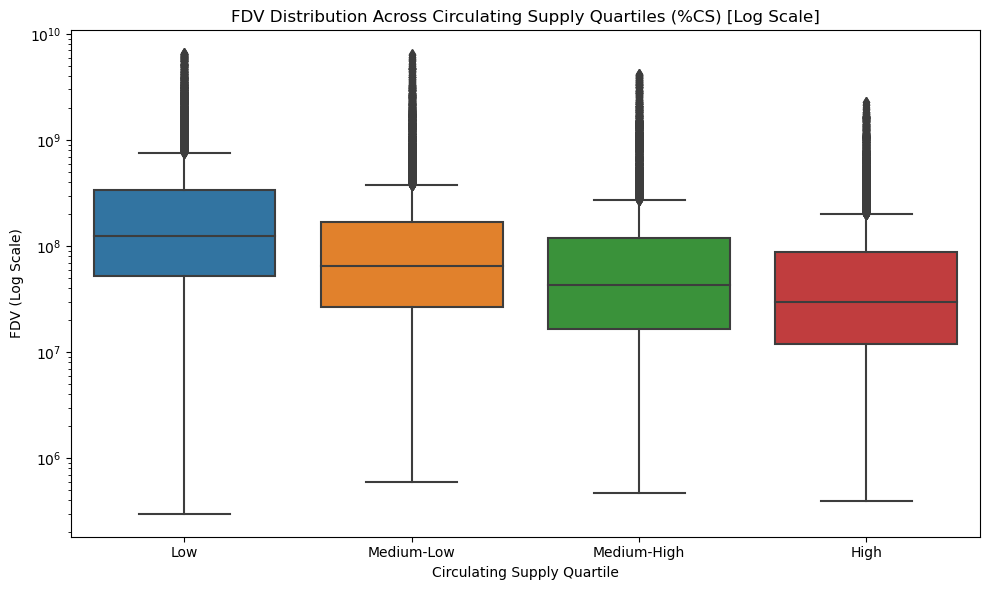

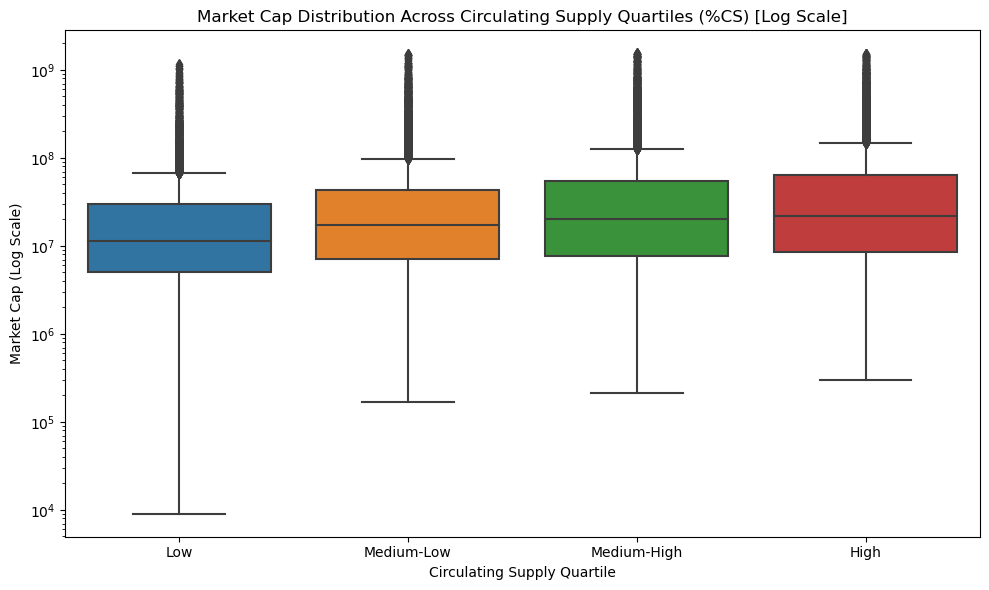

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure cs_ratio exists
df['cs_ratio'] = df['MC'] / df['FDV']

# Define quartiles of %CS
df['cs_quartile'] = pd.qcut(df['cs_ratio'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

# Plot: FDV distribution by %CS quartile
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='cs_quartile', y='FDV')
plt.yscale('log')
plt.xlabel('Circulating Supply Quartile')
plt.ylabel('FDV (Log Scale)')
plt.title('FDV Distribution Across Circulating Supply Quartiles (%CS) [Log Scale]')
plt.tight_layout()
plt.show()

# Plot: MC distribution by %CS quartile
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='cs_quartile', y='MC')
plt.yscale('log')
plt.xlabel('Circulating Supply Quartile')
plt.ylabel('Market Cap (Log Scale)')
plt.title('Market Cap Distribution Across Circulating Supply Quartiles (%CS) [Log Scale]')
plt.tight_layout()
plt.show()


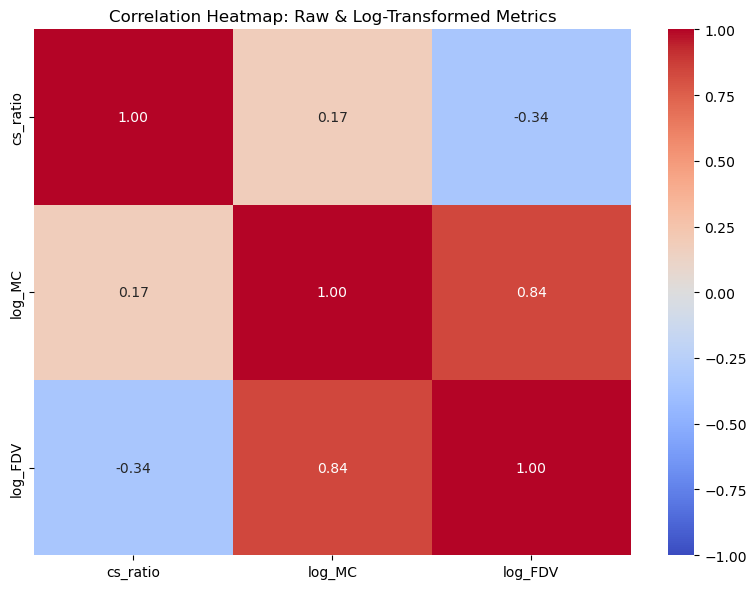

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute log values if not already present
df['log_MC'] = np.log(df['MC'])
df['log_FDV'] = np.log(df['FDV'])

# Select relevant columns
corr_data = df[[ 'cs_ratio', 'log_MC', 'log_FDV']]

# Compute correlation matrix
corr_matrix = corr_data.corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap: Raw & Log-Transformed Metrics")
plt.tight_layout()
plt.show()


# Analysis

In [50]:
import statsmodels.formula.api as smf
import numpy as np

# Rename %CS to a safe variable name for formula parsing
#df = df.rename(columns={'%CS': 'cs_ratio'})

# Add log variables (if not already done)
df['log_FDV'] = np.log(df['FDV'])
df['log_MC'] = np.log(df['MC'])

# Define models
models = {
    'MC ~ cs_ratio': 'MC ~ cs_ratio',
    'FDV ~ cs_ratio': 'FDV ~ cs_ratio',
    'log_MC ~ cs_ratio': 'log_MC ~ cs_ratio',
    'log_FDV ~ cs_ratio': 'log_FDV ~ cs_ratio'
}

print("📊 Cluster-Robust Regressions (p-values & R²):\n")

for name, formula in models.items():
    model = smf.ols(formula, data=df)
    result = model.fit(cov_type='cluster', cov_kwds={'groups': df['symbol']})

    pval = result.pvalues['cs_ratio']
    r2 = result.rsquared

    print(f"{name}: p = {pval:.4g}, R² = {r2:.3f}")


📊 Cluster-Robust Regressions (p-values & R²):

MC ~ cs_ratio: p = 0.0006725, R² = 0.015
FDV ~ cs_ratio: p = 7.941e-14, R² = 0.041
log_MC ~ cs_ratio: p = 2.565e-08, R² = 0.030
log_FDV ~ cs_ratio: p = 3.102e-27, R² = 0.113


In [51]:
import statsmodels.api as sm

# Define your X and Y
X = sm.add_constant(df['cs_ratio'])  
cluster_var = df['symbol']           # clustering variable

# -------- log(MC) ~ %CS --------
model_mc = sm.OLS(df['log_MC'], X).fit(cov_type='cluster', cov_kwds={'groups': cluster_var})
print("🔹 Regression: log(MC) ~ %CS (Cluster-Robust)")
print(model_mc.summary())

# -------- log(FDV) ~ %CS --------
model_fdv = sm.OLS(df['log_FDV'], X).fit(cov_type='cluster', cov_kwds={'groups': cluster_var})
print("\n🔹 Regression: log(FDV) ~ %CS (Cluster-Robust)")
print(model_fdv.summary())


🔹 Regression: log(MC) ~ %CS (Cluster-Robust)
                            OLS Regression Results                            
Dep. Variable:                 log_MC   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     31.01
Date:                Tue, 05 Aug 2025   Prob (F-statistic):           3.47e-08
Time:                        14:20:32   Log-Likelihood:            -1.1782e+05
No. Observations:               66253   AIC:                         2.356e+05
Df Residuals:                   66251   BIC:                         2.357e+05
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const  

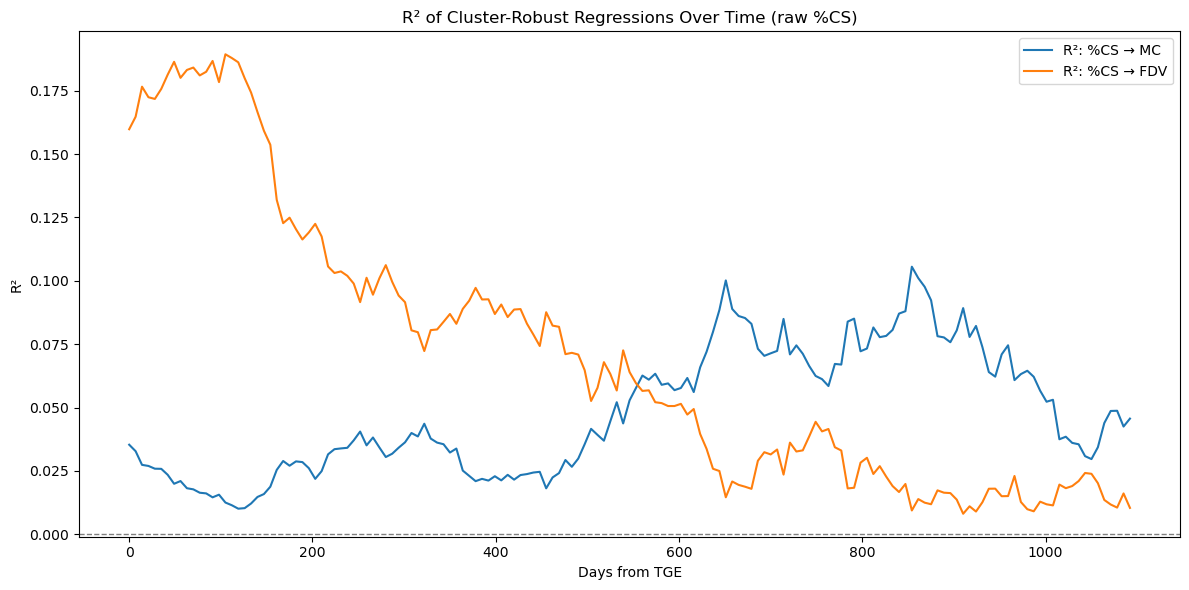

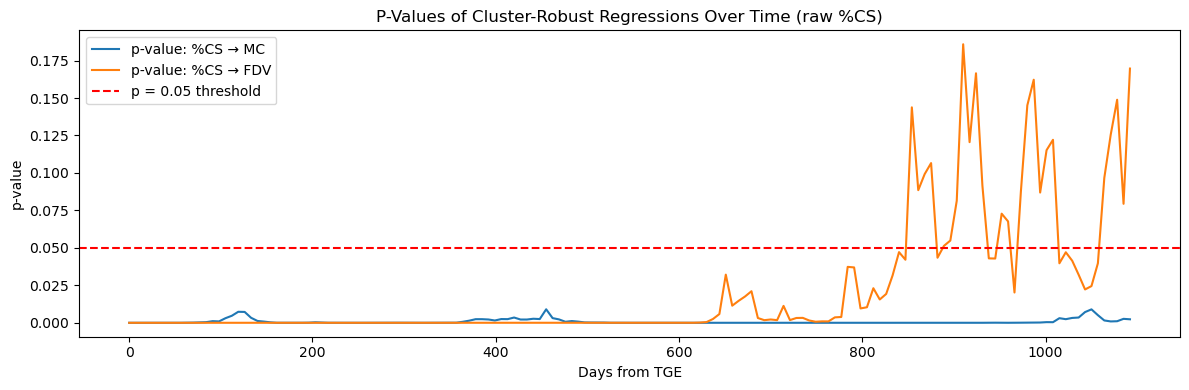

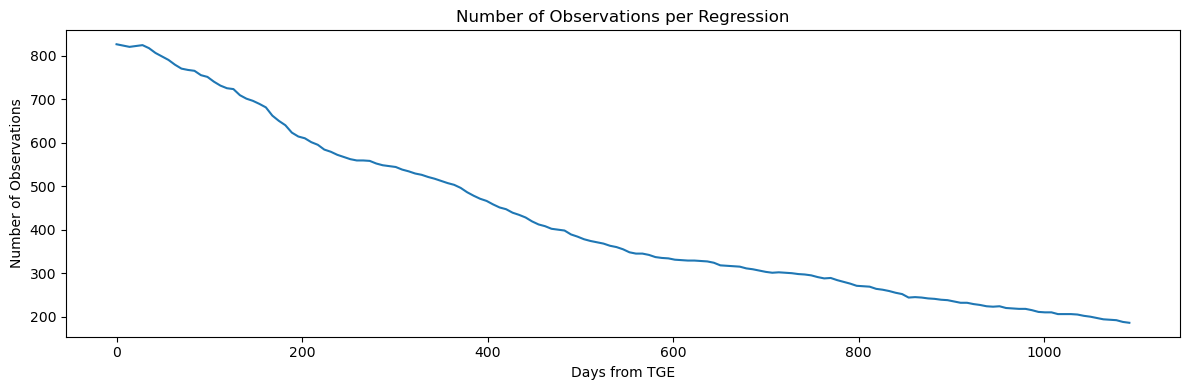

In [52]:
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Collect regression stats
regression_stats = []

for day, group in df.groupby('day_from_TGE'):
    n_obs = len(group)
    n_projects = group['symbol'].nunique()
    if n_projects >= 5:  # at least 5 unique projects
        try:
            mc_model = smf.ols('log_MC ~ cs_ratio', data=group).fit(
                cov_type='cluster', cov_kwds={'groups': group['symbol']}
            )
            fdv_model = smf.ols('log_FDV ~ cs_ratio', data=group).fit(
                cov_type='cluster', cov_kwds={'groups': group['symbol']}
            )

            regression_stats.append({
                'day_from_TGE': day,
                'n_obs': n_obs,
                'n_projects': n_projects,
                'pval_CS_MC': mc_model.pvalues['cs_ratio'],
                'r2_MC': mc_model.rsquared,
                'pval_CS_FDV': fdv_model.pvalues['cs_ratio'],
                'r2_FDV': fdv_model.rsquared
            })
        except:
            continue

# Turn into DataFrame
robust_df = pd.DataFrame(regression_stats).sort_values('day_from_TGE')

# Plot R² over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=robust_df, x='day_from_TGE', y='r2_MC', label='R²: %CS → MC')
sns.lineplot(data=robust_df, x='day_from_TGE', y='r2_FDV', label='R²: %CS → FDV')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("R² of Cluster-Robust Regressions Over Time (raw %CS)")
plt.xlabel("Days from TGE")
plt.ylabel("R²")
plt.legend()
plt.tight_layout()
plt.show()

# Plot p-values over time
plt.figure(figsize=(12, 4))
sns.lineplot(data=robust_df, x='day_from_TGE', y='pval_CS_MC', label='p-value: %CS → MC')
sns.lineplot(data=robust_df, x='day_from_TGE', y='pval_CS_FDV', label='p-value: %CS → FDV')
plt.axhline(0.05, color='red', linestyle='--', label='p = 0.05 threshold')
plt.title("P-Values of Cluster-Robust Regressions Over Time (raw %CS)")
plt.xlabel("Days from TGE")
plt.ylabel("p-value")
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Plot number of observations over time
plt.figure(figsize=(12, 4))
sns.lineplot(data=robust_df, x='day_from_TGE', y='n_obs')
plt.title("Number of Observations per Regression")
plt.xlabel("Days from TGE")
plt.ylabel("Number of Observations")
plt.tight_layout()
plt.show()


In [53]:


csv_path = "bitcoin_market_data.csv"

loaded_df = pd.read_csv(csv_path, parse_dates=['timestamp'])
print("Loaded data from CSV:")
print(loaded_df.head())


Loaded data from CSV:
   timestamp  bitcoin_price
0 2013-04-28         117.00
1 2013-05-05         113.01
2 2013-05-12         115.50
3 2013-05-19         123.00
4 2013-05-26         129.09


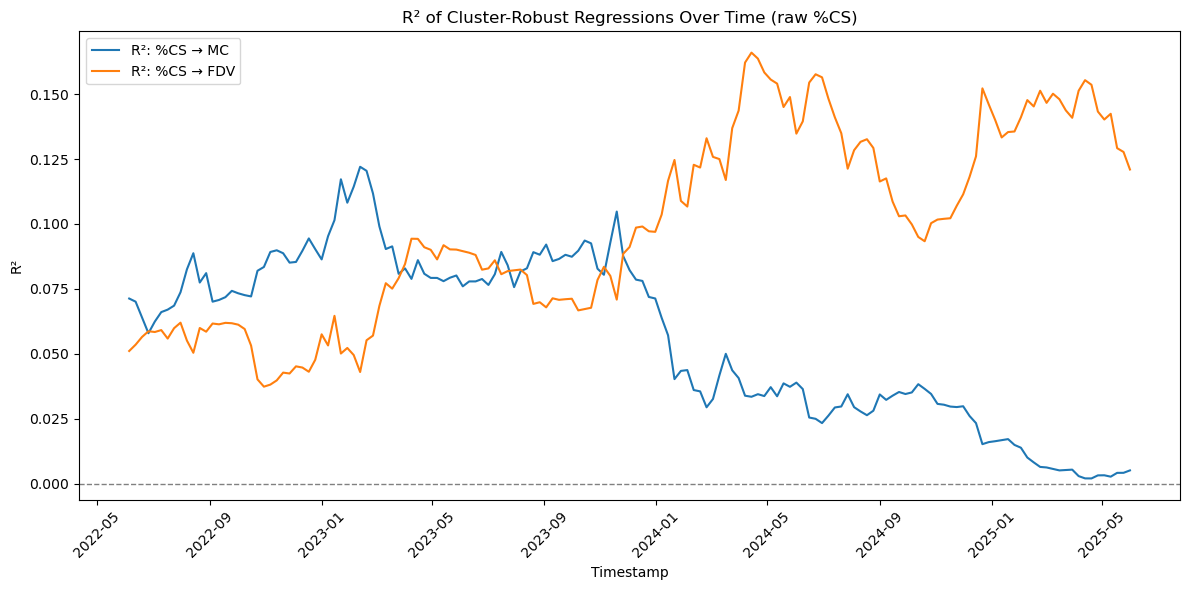

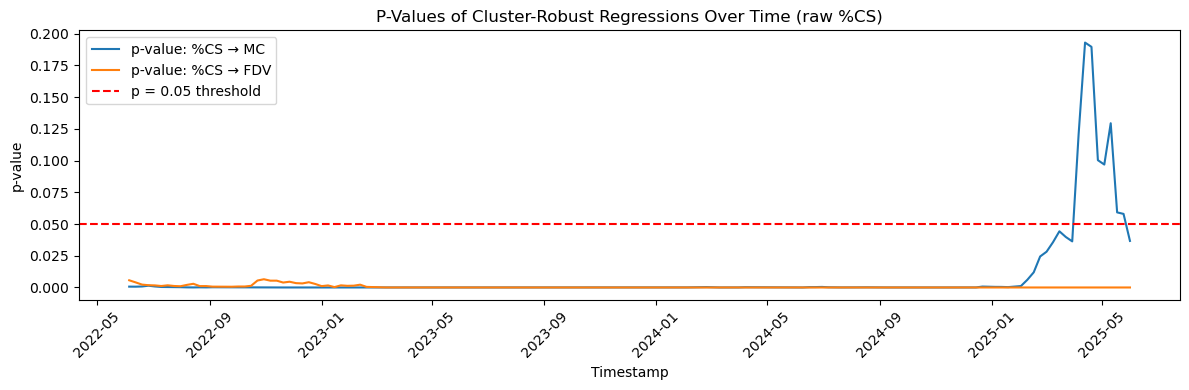

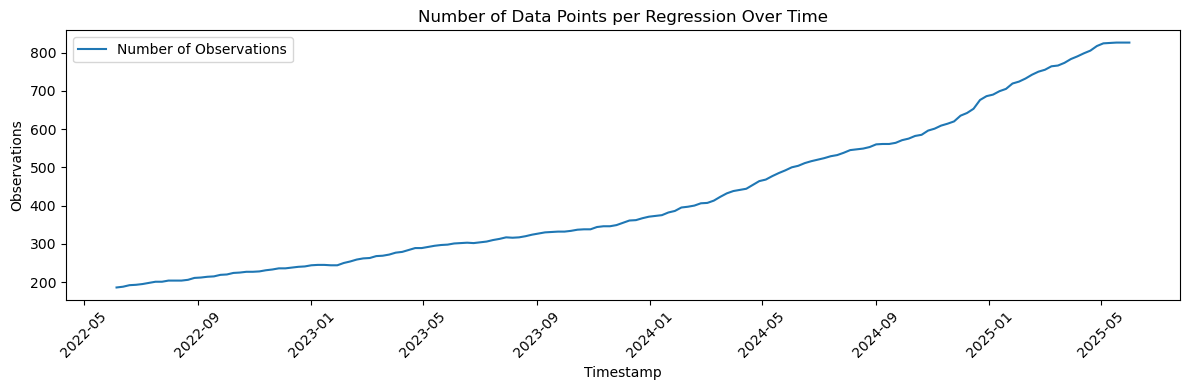

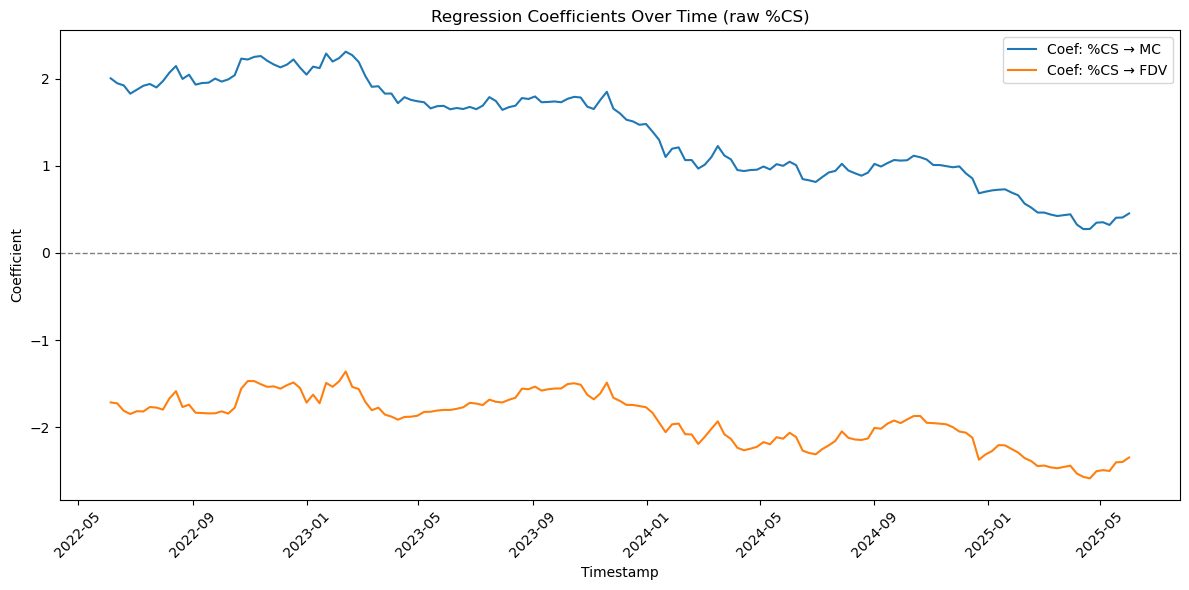

In [54]:
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results = []

# Run cluster-robust regressions for each timestamp
for ts, group in df.groupby('timestamp'):
    if group['symbol'].nunique() >= 5:
        try:
            mc_model = smf.ols('log_MC ~ cs_ratio', data=group).fit(
                cov_type='cluster', cov_kwds={'groups': group['symbol']}
            )
            fdv_model = smf.ols('log_FDV ~ cs_ratio', data=group).fit(
                cov_type='cluster', cov_kwds={'groups': group['symbol']}
            )

            results.append({
                'timestamp': ts,
                'n_obs': len(group),
                'pval_CS_MC': mc_model.pvalues['cs_ratio'],
                'r2_MC': mc_model.rsquared,
                'coef_CS_MC': mc_model.params['cs_ratio'],
                'pval_CS_FDV': fdv_model.pvalues['cs_ratio'],
                'r2_FDV': fdv_model.rsquared,
                'coef_CS_FDV': fdv_model.params['cs_ratio']
            })
        except:
            continue

# Create and sort the result DataFrame
robust_df = pd.DataFrame(results).sort_values('timestamp')

# Plot R² over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=robust_df, x='timestamp', y='r2_MC', label='R²: %CS → MC')
sns.lineplot(data=robust_df, x='timestamp', y='r2_FDV', label='R²: %CS → FDV')
plt.title("R² of Cluster-Robust Regressions Over Time (raw %CS)")
plt.xlabel("Timestamp")
plt.ylabel("R²")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Plot p-values over time
plt.figure(figsize=(12, 4))
sns.lineplot(data=robust_df, x='timestamp', y='pval_CS_MC', label='p-value: %CS → MC')
sns.lineplot(data=robust_df, x='timestamp', y='pval_CS_FDV', label='p-value: %CS → FDV')
plt.axhline(0.05, color='red', linestyle='--', label='p = 0.05 threshold')
plt.title("P-Values of Cluster-Robust Regressions Over Time (raw %CS)")
plt.xlabel("Timestamp")
plt.ylabel("p-value")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Plot number of observations over time
plt.figure(figsize=(12, 4))
sns.lineplot(data=robust_df, x='timestamp', y='n_obs', label='Number of Observations')
plt.title("Number of Data Points per Regression Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Observations")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot regression coefficients over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=robust_df, x='timestamp', y='coef_CS_MC', label='Coef: %CS → MC')
sns.lineplot(data=robust_df, x='timestamp', y='coef_CS_FDV', label='Coef: %CS → FDV')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Regression Coefficients Over Time (raw %CS)")
plt.xlabel("Timestamp")
plt.ylabel("Coefficient")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


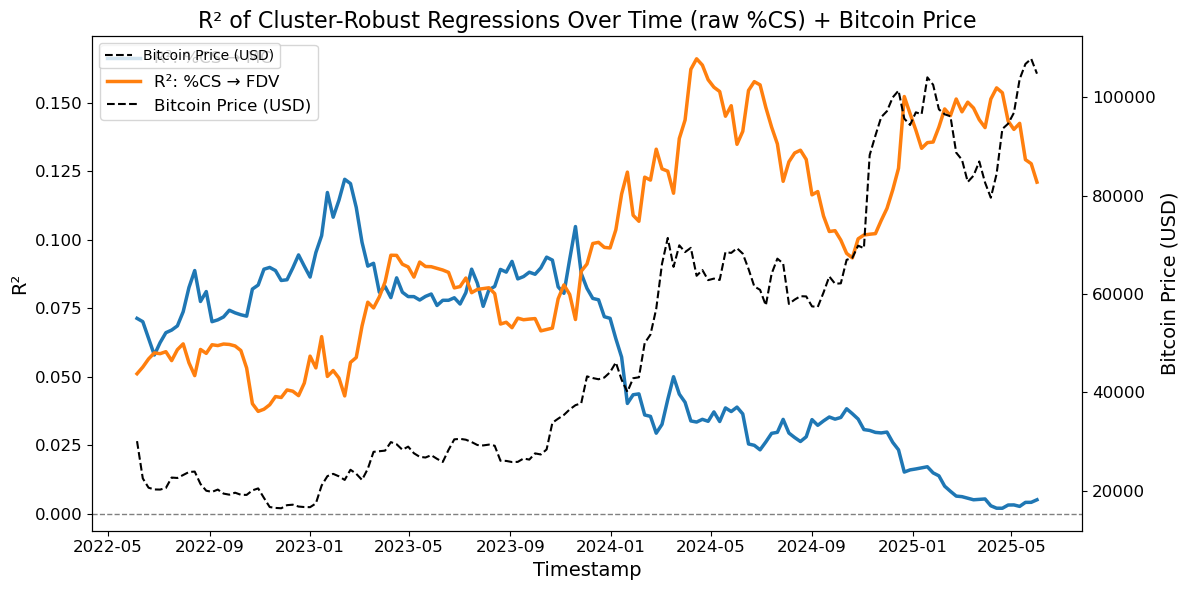

In [55]:
# Ensure timestamps are aligned and timezone-naive
bitcoin_df['timestamp'] = pd.to_datetime(bitcoin_df['timestamp']).dt.tz_localize(None)
robust_df['timestamp'] = pd.to_datetime(robust_df['timestamp'])

# Merge bitcoin price with regression results
merged_df = pd.merge(robust_df, bitcoin_df, on='timestamp', how='left')

# Create dual-axis plot: R² (left), BTC price (right)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left y-axis: R² curves (bold lines)
sns.lineplot(data=merged_df, x='timestamp', y='r2_MC', label='R²: %CS → MC', ax=ax1, linewidth=2.5)
sns.lineplot(data=merged_df, x='timestamp', y='r2_FDV', label='R²: %CS → FDV', ax=ax1, linewidth=2.5)
ax1.set_ylabel('R²', fontsize=14)
ax1.set_xlabel('Timestamp', fontsize=14)
ax1.tick_params(axis='y', labelsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.axhline(0, color='gray', linestyle='--', linewidth=1)

# Right y-axis: BTC price
ax2 = ax1.twinx()
sns.lineplot(data=merged_df, x='timestamp', y='bitcoin_price', label='Bitcoin Price (USD)', ax=ax2, color='black', linestyle='--')
ax2.set_ylabel('Bitcoin Price (USD)', fontsize=14)
ax2.tick_params(axis='y', labelsize=12)

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=12)

# Title and layout
plt.title("R² of Cluster-Robust Regressions Over Time (raw %CS) + Bitcoin Price", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


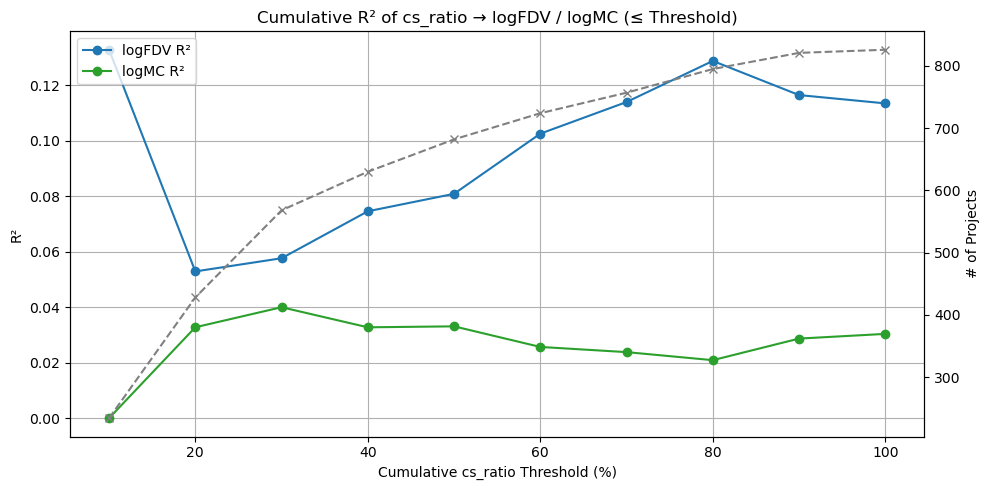

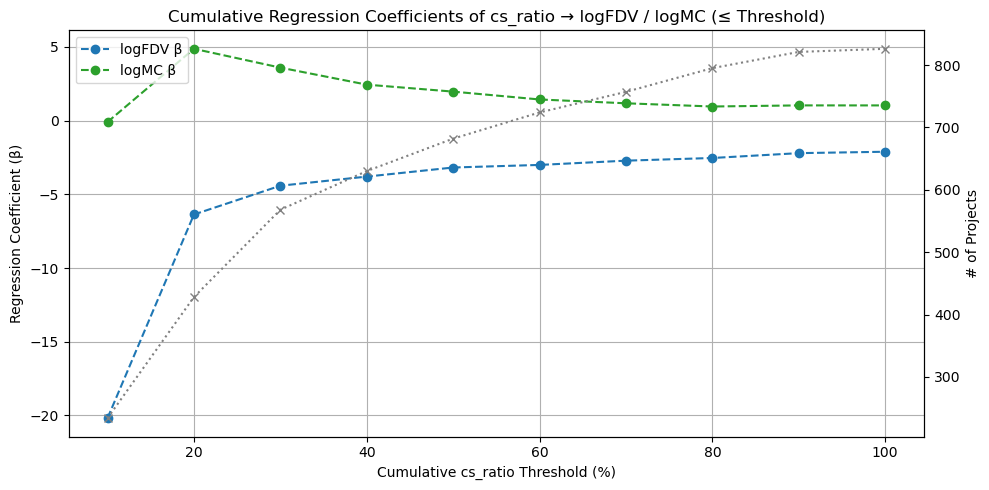

,cs_ratio_max,FDV coef,MC coef,n_tokens
0,0.1,-20.1808,-0.0916,234
1,0.2,-6.3672,4.8742,428
2,0.3,-4.4144,3.5970,568
3,0.4,-3.7957,2.4421,630
4,0.5,-3.1790,1.9692,682
5,0.6,-3.0038,1.4365,724
6,0.7,-2.7153,1.1775,757
7,0.8,-2.5333,0.9594,795
8,0.9,-2.2047,1.0346,821
9,1.0,-2.1099,1.0337,826


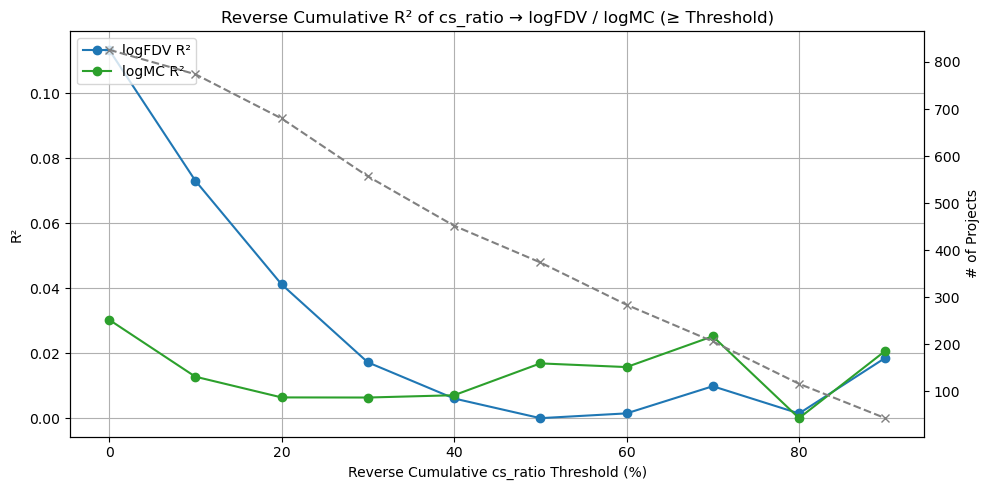

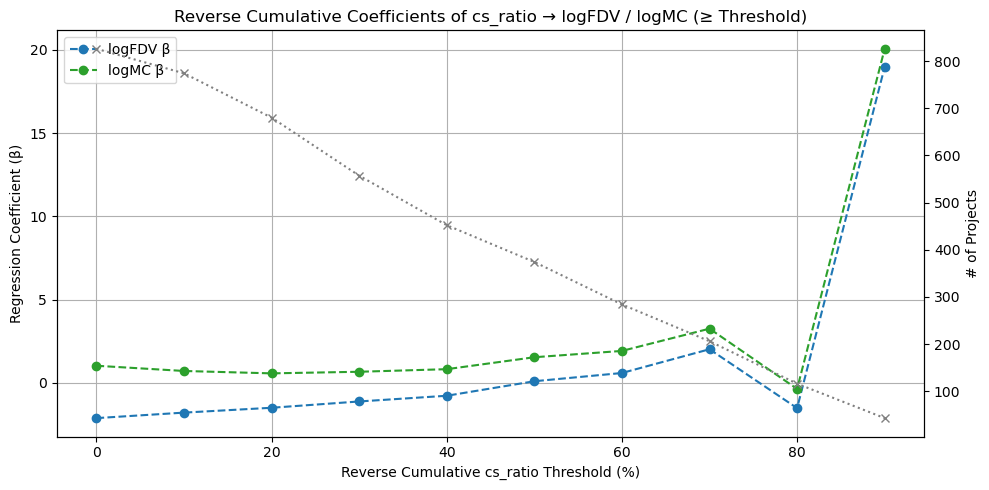

,cs_ratio_min,FDV coef,MC coef,n_tokens
0,0.0,-2.1099,1.0337,826
1,0.1,-1.7796,0.7199,774
2,0.2,-1.4881,0.5765,680
3,0.3,-1.1104,0.6726,557
4,0.4,-0.7678,0.8274,452
5,0.5,0.1039,1.5448,374
6,0.6,0.5982,1.9238,284
7,0.7,2.0245,3.2592,206
8,0.8,-1.5114,-0.3572,116
9,0.9,18.9736,20.0593,43


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# --------------------------
# 1. Regression analysis
# --------------------------
def run_regression_analysis(subset):
    X = sm.add_constant(subset['cs_ratio'])
    fdv_model = sm.OLS(subset['log_FDV'], X).fit()
    mc_model = sm.OLS(subset['log_MC'], X).fit()
    return {
        'n_obs': len(subset),
        'n_tokens': subset['symbol'].nunique(),
        'FDV R²': fdv_model.rsquared,
        'FDV p-value': fdv_model.pvalues['cs_ratio'],
        'FDV coef': fdv_model.params['cs_ratio'],
        'MC R²': mc_model.rsquared,
        'MC p-value': mc_model.pvalues['cs_ratio'],
        'MC coef': mc_model.params['cs_ratio']
    }

# Cumulative (≤ threshold)
under_results = []
for threshold in np.arange(0.1, 1.01, 0.1):
    subset = df[df['cs_ratio'] <= threshold]
    result = run_regression_analysis(subset)
    result['cs_ratio_max'] = threshold
    under_results.append(result)
under_df = pd.DataFrame(under_results)

# Reverse cumulative (≥ threshold)
over_results = []
for threshold in np.arange(0.0, 0.91, 0.1):
    subset = df[df['cs_ratio'] >= threshold]
    result = run_regression_analysis(subset)
    result['cs_ratio_min'] = threshold
    over_results.append(result)
over_df = pd.DataFrame(over_results)

# --------------------------
# 2. Plotting Functions
# --------------------------
def plot_r2_token_count(x, r2_fdv, r2_mc, count, title, xlabel):
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(x, r2_fdv, label="logFDV R²", marker='o', color='tab:blue')
    ax1.plot(x, r2_mc, label="logMC R²", marker='o', color='tab:green')
    ax1.set_ylabel("R²")
    ax1.set_xlabel(xlabel)
    ax1.set_title(title)
    ax1.grid(True)
    ax1.legend(loc="upper left")

    ax2 = ax1.twinx()
    ax2.plot(x, count, label="# of Projects", color="gray", linestyle="--", marker='x')
    ax2.set_ylabel("# of Projects")

    fig.tight_layout()
    plt.show()

def plot_coef_token_count(x, coef_fdv, coef_mc, count, title, xlabel, table_data=None):
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(x, coef_fdv, label="logFDV β", marker='o', color='tab:blue', linestyle='--')
    ax1.plot(x, coef_mc, label="logMC β", marker='o', color='tab:green', linestyle='--')
    ax1.set_ylabel("Regression Coefficient (β)")
    ax1.set_xlabel(xlabel)
    ax1.set_title(title)
    ax1.grid(True)
    ax1.legend(loc="upper left")

    ax2 = ax1.twinx()
    ax2.plot(x, count, label="# of Projects", color="gray", linestyle=":", marker='x')
    ax2.set_ylabel("# of Projects")

    fig.tight_layout()
    plt.show()

    if table_data is not None:
        display_cols = ['FDV coef', 'MC coef', 'n_tokens']
        if 'Window Center' in table_data.columns:
            display_cols = ['Window Center'] + display_cols
        elif 'cs_ratio_max' in table_data.columns:
            display_cols = ['cs_ratio_max'] + display_cols
        elif 'cs_ratio_min' in table_data.columns:
            display_cols = ['cs_ratio_min'] + display_cols

        display(table_data[display_cols].round(4))

# --------------------------
# 3. Generate 4 plots
# --------------------------

# Cumulative R²
plot_r2_token_count(
    under_df['cs_ratio_max'] * 100,
    under_df['FDV R²'],
    under_df['MC R²'],
    under_df['n_tokens'],
    "Cumulative R² of cs_ratio → logFDV / logMC (≤ Threshold)",
    "Cumulative cs_ratio Threshold (%)"
)

# Cumulative β
plot_coef_token_count(
    under_df['cs_ratio_max'] * 100,
    under_df['FDV coef'],
    under_df['MC coef'],
    under_df['n_tokens'],
    "Cumulative Regression Coefficients of cs_ratio → logFDV / logMC (≤ Threshold)",
    "Cumulative cs_ratio Threshold (%)",
    table_data=under_df
)

# Reverse Cumulative R²
plot_r2_token_count(
    over_df['cs_ratio_min'] * 100,
    over_df['FDV R²'],
    over_df['MC R²'],
    over_df['n_tokens'],
    "Reverse Cumulative R² of cs_ratio → logFDV / logMC (≥ Threshold)",
    "Reverse Cumulative cs_ratio Threshold (%)"
)

# Reverse Cumulative β
plot_coef_token_count(
    over_df['cs_ratio_min'] * 100,
    over_df['FDV coef'],
    over_df['MC coef'],
    over_df['n_tokens'],
    "Reverse Cumulative Coefficients of cs_ratio → logFDV / logMC (≥ Threshold)",
    "Reverse Cumulative cs_ratio Threshold (%)",
    table_data=over_df
)


In [57]:
fdv_df.sort_values('market_cap', ascending=False)

,timestamp,token_id,token_name,fdv,market_cap
402870,2021-10-31,1a481d76-a783-46ad-8f45-d093fccf65bd,Shiba Inu,3.571439e+10,3.571439e+10
402871,2021-11-07,1a481d76-a783-46ad-8f45-d093fccf65bd,Shiba Inu,3.483268e+10,3.483268e+10
402872,2021-11-14,1a481d76-a783-46ad-8f45-d093fccf65bd,Shiba Inu,3.025565e+10,3.025565e+10
402873,2021-11-21,1a481d76-a783-46ad-8f45-d093fccf65bd,Shiba Inu,2.674463e+10,2.674463e+10
457758,2024-05-19,76bdf9a4-10f0-4cfe-b8c0-9123a7e3e7c6,Toncoin,2.380661e+10,2.380661e+10
...,...,...,...,...,...
531298,2024-12-22,9542b9c1-8f21-4eb4-88b1-0282aa7cdc8b,ZUSD,NaN,NaN
531299,2024-12-29,9542b9c1-8f21-4eb4-88b1-0282aa7cdc8b,ZUSD,NaN,NaN
531300,2025-01-05,9542b9c1-8f21-4eb4-88b1-0282aa7cdc8b,ZUSD,NaN,NaN
531301,2025-01-12,9542b9c1-8f21-4eb4-88b1-0282aa7cdc8b,ZUSD,NaN,NaN
